In [ ]:
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import tqdm
import pandas as pd
import numpy as np
import warnings
import sys
import gc

from sklearn import model_selection
from catboost import CatBoostClassifier
warnings.filterwarnings('ignore')

# <b><div style='padding:15px;background-color:#1758B3;color:white;border-radius:5px;font-size:80%;font-family:"Verdana"'>Introduction</div></b>

##### <p style='font-family:"Verdana";line-height: 1.7;'>If we look at the dataset, we can see there is one column in the datset corrosponding to statement date. In this notebook we will explore how other features has been changed from customers statement date. As an example we will explore how customer's balance features has changed over his/her deferent statement dates. Below you can see how statements distributed accross the train and test datasets. Image borrowed from -[ambrosm](https://www.kaggle.com/code/ambrosm/amex-eda-which-makes-sense)

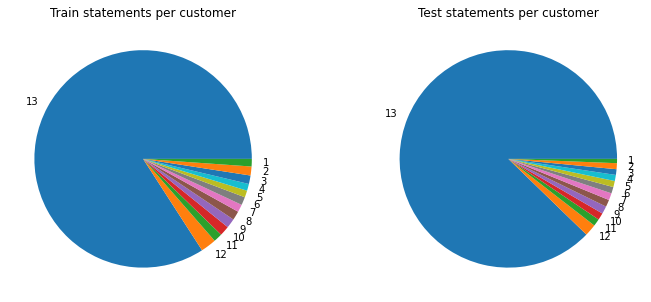

**Methodlogy used in below figures.**

##### <p style='font-family:"Verdana";line-height: 1.7;'>First read first 200K samples in training dataset. Then ranked each customers statement and declare the column representing statement sequance. Then analyzed how each feature changed over diferent statement dates. For both Non default and Default segmants I've used same instance count(200) when plotting

In [ ]:
DEFAULT_COLOR = '#FF5F00'
NON_DEFAULT_COLOR = '#003D93'
TXT_BACK_ND = '#40C895'
TXT_BACK_D = '#E37D1D'
N = 200

In [ ]:
reader = pd.read_csv("../input/amex-default-prediction/train_data.csv",chunksize=200_000,iterator=True)
labels = pd.read_csv('../input/amex-default-prediction/train_labels.csv',index_col='customer_ID')

In [ ]:
df = next(reader)
na_pct = df.isna().sum()/len(df)
cols_to_drop = na_pct[na_pct>0.90].index.tolist()

df['S_2'] = pd.DatetimeIndex(df['S_2'])
df.drop(cols_to_drop,axis=1,inplace=True)

all_feats = df.select_dtypes(exclude='object').columns.tolist()

df['date_rank'] = df.groupby("customer_ID")["S_2"].rank("dense")

In [ ]:
def plot_features_vs_time(features,name,figsize=(20,70)):
    N_COLS = 4
    N_ROWS = int(np.ceil(len(features)/2))

    fig,ax = plt.subplots(N_ROWS,N_COLS,figsize=figsize,constrained_layout=True)
    axi = ax.reshape(-1,2)

    for i,feature in enumerate(features):

        feat_df = df[[feature]+['customer_ID','date_rank']]
        feat_df = feat_df.pivot_table(index='customer_ID',columns='date_rank')[feature]
        feat_df = feat_df.join(labels)
        feat_df_1 = feat_df[feat_df.target==1]
        feat_df_0 = feat_df[feat_df.target==0]
    #     print(i,feature)
        for x in range(N):
            axi[i][0].plot(feat_df_1.iloc[x,range(13)],color=DEFAULT_COLOR,alpha=x/N);
            axi[i][0].grid('True');
            axi[i][0].set_title(label=f'Feature:{feature} [Default]',fontweight='semibold',fontfamily='serif',backgroundcolor=TXT_BACK_D)

            axi[i][1].plot(feat_df_0.iloc[x,range(13)],color=NON_DEFAULT_COLOR,alpha=x/N);
            axi[i][1].grid('True');
            axi[i][1].set_title(label=f'Feature:{feature} [Non Default]',fontweight='semibold',fontfamily='serif',backgroundcolor=TXT_BACK_ND)

    fig.suptitle(f'{name} Over Time Period\n\n',fontweight='bold',fontfamily='serif',fontsize=19)
    # plt.tight_layout()
    plt.show()

# <b><div style='padding:15px;background-color:#1758B3;color:white;border-radius:5px;font-size:80%;font-family:"Verdana"'>1. Balance features vs. Statement date</div></b>

In [ ]:
balance_features = [col for col in all_feats if col.startswith('B')]
plot_features_vs_time(balance_features,name='Balance Features')

# <b><div style='padding:15px;background-color:#1758B3;color:white;border-radius:5px;font-size:60%;font-family:"Verdana"'>1.1 Insights</div></b>

##### <p style='font-family:"Verdana";line-height: 1.7;'>As per the plots above, we can notice some significant insights.</p>
* **B_4** - In **Default** users, ~90% of B_4 feature distributed between 0-1. This range differ for **Non Default** users which is 0-0.5 .
* **B_6** - For **Default** users this feature range from 0.0 to ~0.25. For **Non Default** users it's from 0.00 to ~1.0.
* **B_7** - For **Default** users this feature almost evenly distributed betwwen 0.0 and 1.0 For **Non Default** users this feature packed betwwen 0 and 0.1 .
* **B_23** - Almost same behaviour as B_7. But range may differ.
* **B_36** - As per plots, it seems there is significance deference in two cases. Have to re-check confirm it further since plots' scales are different.(Todo)
* **B_41** - Seems there is signifinact diference. For **default** users upper and lower bundry is 1.00 and 0.00, for **Non Default** users this there is no clear upper boundry. The lower boundry is 0.00.(For Non Default users this feature almost 0)

# <b><div style='padding:15px;background-color:#1758B3;color:white;border-radius:5px;font-size:80%;font-family:"Verdana"'>2. Delinquency features vs. Statement date</div></b>

In [ ]:
delinquent_features = [col for col in all_feats if col.startswith('D')]
plot_features_vs_time(delinquent_features,name='Delinquent Features',figsize=(20,100))

# <b><div style='padding:15px;background-color:#1758B3;color:white;border-radius:5px;font-size:60%;font-family:"Verdana"'>2.1 Insights</div></b>

##### <p style='font-family:"Verdana";line-height: 1.7;'>Being delinquent refers to the state of being past due on a debt. Delinquency occurs as soon as a borrower misses a payment on a loan, which can affect their credit score.<br>Ref- www.investopedia.com</p>

* **D_48** - In **Default** users this value skewed towards to 0.5 to 1. In **Non Default** users majority values between 0.5 and 1.0 .
* **D_54** - For **Default** users this feature has clear lower and upper boundries, respectively 0 & 1. For **Non Default** users this value is almost 1.0 .
* **D_79** - For **Default** users this feature is 0,0.5,1 or 1.5 (Most cases), but for **Non Default** users this is differ.0.0, 0.5 and 1.0
* **D_86 & D_127** - Kindof same **D_54** behaviour.

# <b><div style='padding:15px;background-color:#1758B3;color:white;border-radius:5px;font-size:80%;font-family:"Verdana"'>3. Risk features vs. Statement date</div></b>

In [ ]:
risk_features = [col for col in all_feats if col.startswith('R')]
plot_features_vs_time(risk_features,name='Risk Features',figsize=(20,30))

# <b><div style='padding:15px;background-color:#1758B3;color:white;border-radius:5px;font-size:60%;font-family:"Verdana"'>3.1 Insights</div></b>

##### <p style='font-family:"Verdana";line-height: 1.7;'>In most cases we couldn't see clear signals that we can segregrate two bases. Found below tiny decision points. </p>

 - **R_2 and R_4** - For **Non Default** users this value keep same (0) accross the statement dates.
 - **R_19 and R_21** - For **Non Default** users this value is almost 0

# <b><div style='padding:15px;background-color:#1758B3;color:white;border-radius:5px;font-size:80%;font-family:"Verdana"'>4. Payment features vs. Statement date</div></b>

In [ ]:
payment_features = [col for col in all_feats if col.startswith('P')]
plot_features_vs_time(payment_features,name='Payment Features',figsize=(20,8))

# <b><div style='padding:15px;background-color:#1758B3;color:white;border-radius:5px;font-size:60%;font-family:"Verdana"'>4.1 Insights</div></b>

##### <p style='font-family:"Verdana";line-height: 1.7;'>For Payment feature, I could not notice clear signals.</p>

# <b><div style='padding:15px;background-color:#1758B3;color:white;border-radius:5px;font-size:80%;font-family:"Verdana"'>5. Spend features vs. Statement date</div></b>

In [ ]:
spend_features = [col for col in all_feats if col.startswith('S')]
spend_features.remove('S_2')
plot_features_vs_time(spend_features,name='Spend Features',figsize=(20,30))

# <b><div style='padding:15px;background-color:#1758B3;color:white;border-radius:5px;font-size:60%;font-family:"Verdana"'>5.1 Insights</div></b>

##### <p style='font-family:"Verdana";line-height: 1.7;'>Below are the noticeable signal in Payment features</p>

* **S_22 and S_24** - For **Default** users this feature almost 0, and **Non Default** users this is more skewed towards to 1.0.

In [ ]:
%whos DataFrame

In [ ]:
del df;del labels;gc.collect()

# <b><div style='padding:15px;background-color:#1758B3;color:white;border-radius:5px;font-size:80%;font-family:"Verdana"'>6. Conclusion</div></b>

##### <p style='font-family:"Verdana";line-height: 1.7;'>Aim of this notebook it provide one way to understand given dataset. Above insight may differ for different customer sample. You may do your own research before using these insights for your modeling/Analysis. If you noticed any mistake above, please let me know. Glad to fix them.</p>

# <b><div style='padding:15px;background-color:#1758B3;color:white;border-radius:5px;font-size:80%;font-family:"Verdana";text-align:center'>Thank you!</div></b>